In [15]:
# import sys
# print(sys.path)
# sys.path.append("<local-root-path>/src/")
# sys.path.insert(0, "<local-root-path>/src/modeling")
# sys.path.insert(0, "<local-root-path>/src/plotting")
# sys.path.insert(0, "<local-root-path>/src/predicting")
#python -m install --user -r "wvd.txt"


import constant as const
import numpy as np
import tensorflow as tf
import plotting_utils
import predicting_utils

In [16]:
import train_rl_model


### Define RL modules [locally]

Define a [MovieLens-specific bandits environment](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/environments/movielens_py_environment/MovieLensPyEnvironment), a [Linear UCB agent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent) and the [regret metric](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/metrics/tf_metrics/RegretMetric).

In [17]:
print(const.PROFILER_DIR)
tf.profiler.experimental.start(const.PROFILER_DIR)
environment = train_rl_model.define_rl_envirioment()
agent = train_rl_model.define_rl_agent(environment)
metrics = train_rl_model.define_rl_metric(environment)

C:/Users/jacob/Documents/GitHub/rl-recommender-systems/src/artifacts/profiler


### Train the model [locally]

Define the training logic (on-policy training). The following function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/bandits/agents/examples/v2/trainer.py#L104), but it keeps track of intermediate metric values and saves different artifacts to different locations. You can also directly invoke [trainer.train](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/bandits/agents/examples/v2/trainer.py#L104) which also trains the policy.

Train the RL policy and gather intermediate metric results. At the same time, use [TensorBoard Profiler](https://www.tensorflow.org/guide/profiler) to profile the training process and resources.

In [18]:
metric_results = train_rl_model.train(
    root_dir=const.ROOT_DIR,
    agent=agent,
    environment=environment,
    training_loops=const.TRAINING_LOOPS,
    steps_per_loop=const.STEPS_PER_LOOP,
    additional_metrics=metrics)

tf.profiler.experimental.stop()

INFO:tensorflow:Assets written to: C:/Users/jacob/Documents/GitHub/rl-recommender-systems/src/artifacts\assets


C:\Users\jacob\.conda\envs\recsim\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: C:/Users/jacob/Documents/GitHub/rl-recommender-systems/src/artifacts\assets


### Evaluate RL metrics [locally]

You can visualize how the regret and average return metrics evolve over training steps.

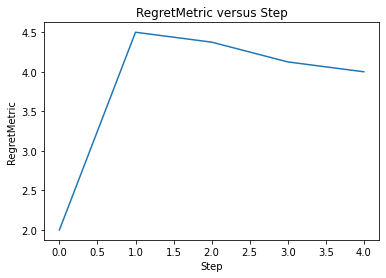

In [19]:
plotting_utils.plot(metric_results, "RegretMetric")

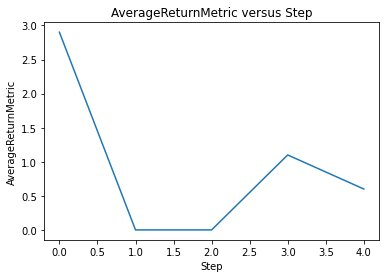

In [20]:
plotting_utils.plot(metric_results, "AverageReturnMetric")

### Create custom prediction container

As with training, create a custom prediction container. This container handles the TF-Agents specific logic that is different from a regular TensorFlow Model. Specifically, it finds the predicted action using a trained policy.

#### Serve predictions:
- Use [`tensorflow.saved_model.load`](https://www.tensorflow.org/agents/api_docs/python/tf_agents/policies/PolicySaver#usage), instead of [`tf_agents.policies.policy_loader.load`](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/policies/policy_loader.py#L26), to load the trained policy, because the latter produces an object of type [`SavedModelPyTFEagerPolicy`](https://github.com/tensorflow/agents/blob/402b8aa81ca1b578ec1f687725d4ccb4115386d2/tf_agents/policies/py_tf_eager_policy.py#L137) whose `action()` is not compatible for use here.
- Note that prediction requests contain only observation data but not reward. This is because: The prediction task is a standalone request that doesn't require prior knowledge of the system state. Meanwhile, end users only know what they observe at the moment. Reward is a piece of information that comes after the action has been made, so the end users would not have knowledge of said reward. In handling prediction requests, you create a [`TimeStep`](https://www.tensorflow.org/agents/api_docs/python/tf_agents/trajectories/TimeStep) object (consisting of `observation`, `reward`, `discount`, `step_type`) using the [`restart()`](https://www.tensorflow.org/agents/api_docs/python/tf_agents/trajectories/restart) function which takes in an `observation`. This function creates the *first* TimeStep in a trajectory of steps, where reward is 0, discount is 1 and step_type is marked as the first timestep. In other words, each prediction request forms the first `TimeStep` in a brand new trajectory.
- For the prediction response, avoid using NumPy-typed values; instead, convert them to native Python values using methods such as [`tolist()`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.tolist.html) as opposed to `list()`.

### Predict on the Endpoint
- Put prediction input(s) into a list named `instances`. The observation should of dimension (BATCH_SIZE, RANK_K). Read more about the MovieLens simulation environment observation [here](https://github.com/tensorflow/agents/blob/v0.8.0/tf_agents/bandits/environments/movielens_py_environment.py#L32-L138).

In [21]:
recommended_movie_ids = predicting_utils.predict_observations_by_users(observation = {"observation": [list(np.ones(20)) for _ in range(8)]})

ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (2 total):
    * TimeStep(
{'discount': <tf.Tensor 'time_step_2:0' shape=(8,) dtype=float32>,
 'observation': {'observation': [[<tf.Tensor 'time_step_3:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_4:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_5:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_6:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_7:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_8:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_9:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_10:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_11:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_12:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_13:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_14:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_15:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_16:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_17:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_18:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_19:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_20:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_21:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_22:0' shape=() dtype=float64>],
                                 [<tf.Tensor 'time_step_23:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_24:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_25:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_26:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_27:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_28:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_29:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_30:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_31:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_32:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_33:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_34:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_35:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_36:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_37:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_38:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_39:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_40:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_41:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_42:0' shape=() dtype=float64>],
                                 [<tf.Tensor 'time_step_43:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_44:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_45:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_46:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_47:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_48:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_49:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_50:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_51:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_52:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_53:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_54:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_55:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_56:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_57:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_58:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_59:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_60:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_61:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_62:0' shape=() dtype=float64>],
                                 [<tf.Tensor 'time_step_63:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_64:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_65:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_66:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_67:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_68:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_69:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_70:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_71:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_72:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_73:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_74:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_75:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_76:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_77:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_78:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_79:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_80:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_81:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_82:0' shape=() dtype=float64>],
                                 [<tf.Tensor 'time_step_83:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_84:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_85:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_86:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_87:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_88:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_89:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_90:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_91:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_92:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_93:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_94:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_95:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_96:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_97:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_98:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_99:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_100:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_101:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_102:0' shape=() dtype=float64>],
                                 [<tf.Tensor 'time_step_103:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_104:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_105:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_106:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_107:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_108:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_109:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_110:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_111:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_112:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_113:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_114:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_115:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_116:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_117:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_118:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_119:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_120:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_121:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_122:0' shape=() dtype=float64>],
                                 [<tf.Tensor 'time_step_123:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_124:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_125:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_126:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_127:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_128:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_129:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_130:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_131:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_132:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_133:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_134:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_135:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_136:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_137:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_138:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_139:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_140:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_141:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_142:0' shape=() dtype=float64>],
                                 [<tf.Tensor 'time_step_143:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_144:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_145:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_146:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_147:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_148:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_149:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_150:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_151:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_152:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_153:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_154:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_155:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_156:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_157:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_158:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_159:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_160:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_161:0' shape=() dtype=float64>,
                                  <tf.Tensor 'time_step_162:0' shape=() dtype=float64>]]},
 'reward': <tf.Tensor 'time_step_1:0' shape=(8,) dtype=float32>,
 'step_type': <tf.Tensor 'time_step:0' shape=(8,) dtype=int32>})
    * ()
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (2 total):
    * TimeStep(step_type=TensorSpec(shape=(None,), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(None,), dtype=tf.float32, name='reward'), discount=TensorSpec(shape=(None,), dtype=tf.float32, name='discount'), observation=TensorSpec(shape=(None, 20), dtype=tf.float64, name='observation'))
    * ()
  Keyword arguments: {}

Option 2:
  Positional arguments (2 total):
    * TimeStep(step_type=TensorSpec(shape=(None,), dtype=tf.int32, name='time_step/step_type'), reward=TensorSpec(shape=(None,), dtype=tf.float32, name='time_step/reward'), discount=TensorSpec(shape=(None,), dtype=tf.float32, name='time_step/discount'), observation=TensorSpec(shape=(None, 20), dtype=tf.float64, name='time_step/observation'))
    * ()
  Keyword arguments: {}